**Data Mining Project, midterm 2021/2022**

**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

#**Task 4.1 Time Series Analysis**

## **Import the libraries and load the city temperature dataset**

First we have to import the necessary libraries to work within our project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
import seaborn as sn

Clone the repository and load the dataset from it.

In [2]:
!git clone 'https://github.com/nikodallanoce/DataMiningProject/'

Cloning into 'DataMiningProject'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (367/367), done.
remote: Compressing objects: 100% (341/341), done.
remote: Total 367 (delta 109), reused 23 (delta 2), pack-reused 0
Receiving objects: 100% (367/367), 56.92 MiB | 11.71 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [3]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
df_cities_temperatures = pd.read_csv('/content/DataMiningProject/DM_14_TASK4/CityGlobalTemperature.csv', sep=",", index_col=0, parse_dates=["time"], date_parser=dateparse)
df_cities_temperatures

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,time
1813,27.685,0.267,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-02-01
1814,29.061,0.224,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-03-01
1815,28.162,0.478,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-04-01
1816,27.547,0.509,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-05-01
1817,25.812,0.231,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-06-01
...,...,...,...,...,...,...,...
239128,18.459,0.374,Xian,China,34.56N,108.97E,2009-09-01
239129,14.195,0.163,Xian,China,34.56N,108.97E,2009-10-01
239130,2.916,0.675,Xian,China,34.56N,108.97E,2009-11-01
239131,-0.712,0.259,Xian,China,34.56N,108.97E,2009-12-01


In [4]:
df_cities_temperatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1813 to 239132
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   AverageTemperature             12000 non-null  float64       
 1   AverageTemperatureUncertainty  12000 non-null  float64       
 2   City                           12000 non-null  object        
 3   Country                        12000 non-null  object        
 4   Latitude                       12000 non-null  object        
 5   Longitude                      12000 non-null  object        
 6   time                           12000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 750.0+ KB


## **Some time series plots**

Plot some time series to better understand how the dataset is built.

Build new dataframes (df_cities for the shape clustering analysis and df_cities_months to plot).

In [5]:
df_cities = df_cities_temperatures.pivot(index="City", columns="time", values="AverageTemperature")
df_cities_months = df_cities_temperatures.pivot(index="time", columns="City", values="AverageTemperature")
df_cities

time,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,2001-06-01,2001-07-01,2001-08-01,2001-09-01,2001-10-01,2001-11-01,2001-12-01,2002-01-01,2002-02-01,2002-03-01,2002-04-01,2002-05-01,2002-06-01,2002-07-01,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,2003-04-01,2003-05-01,...,2006-10-01,2006-11-01,2006-12-01,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,2007-10-01,2007-11-01,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abidjan,27.685,29.061,28.162,27.547,25.812,24.870,24.884,25.405,26.074,27.315,26.929,26.920,28.234,28.706,27.702,27.653,25.940,24.841,24.280,24.797,26.278,27.374,27.598,27.192,28.796,28.564,28.508,27.721,25.972,25.054,24.580,25.260,26.076,27.282,27.087,27.590,28.863,28.980,28.169,27.910,...,26.396,27.375,27.397,27.120,28.986,29.106,28.334,27.702,26.134,25.417,25.004,25.606,26.074,27.232,27.367,26.061,28.773,28.819,28.156,27.366,26.276,25.652,25.219,25.557,26.681,27.302,27.472,26.912,28.224,28.805,28.001,27.766,26.655,25.437,24.945,25.568,26.354,27.497,27.620,28.270
Addis Abeba,19.183,20.230,20.398,19.977,18.254,17.109,16.944,17.542,17.113,17.741,17.013,17.454,18.864,20.043,20.233,19.908,17.978,17.011,17.152,17.867,18.047,17.306,17.694,17.901,19.471,20.193,20.097,20.234,18.084,17.518,17.171,17.405,17.324,17.964,18.275,18.201,19.210,20.453,20.270,20.409,...,17.799,17.793,17.285,18.484,18.959,20.045,19.619,19.805,17.998,17.002,16.905,17.192,17.108,17.502,17.092,18.773,19.493,19.735,19.704,19.459,17.899,16.853,16.960,17.736,17.460,16.950,16.958,17.963,19.824,20.189,20.335,20.283,19.222,17.484,17.513,18.187,17.788,18.098,18.298,18.390
Ahmadabad,21.246,26.565,32.275,32.847,32.490,28.678,28.616,29.087,29.285,25.577,21.785,19.770,22.438,27.198,31.034,33.358,30.717,27.730,27.893,29.490,29.073,25.516,22.160,19.831,22.333,27.885,32.020,34.317,32.522,29.698,28.036,28.558,29.507,25.437,22.485,21.006,23.304,27.331,31.887,33.511,...,28.415,25.325,21.913,20.697,23.644,27.121,32.205,33.748,32.307,29.124,27.979,28.836,27.604,25.621,21.248,19.179,20.244,28.023,30.922,32.850,31.186,28.985,27.246,28.485,28.694,25.452,23.316,21.615,24.194,28.640,31.847,34.075,32.957,29.426,29.072,29.360,28.299,25.187,22.478,20.969
Aleppo,6.832,10.421,17.743,22.240,27.781,31.957,29.873,25.877,18.846,13.380,7.636,7.306,8.787,14.904,17.666,21.191,27.922,30.727,30.330,26.419,20.153,11.430,8.173,4.806,9.745,12.984,15.722,21.571,27.554,30.407,29.396,26.078,21.185,13.707,5.473,7.598,6.078,9.830,16.322,24.059,...,19.773,11.031,5.837,4.724,8.351,12.045,14.404,24.139,28.113,31.132,30.266,26.777,21.270,12.863,6.622,3.063,7.025,15.067,19.416,21.837,28.119,30.787,31.206,26.287,19.988,13.711,6.575,5.742,8.866,11.099,16.305,22.188,28.337,30.216,29.833,24.927,21.477,12.324,9.943,8.779
Alexandria,14.300,15.266,19.556,21.828,24.619,27.091,26.930,25.939,22.842,20.524,16.460,15.312,15.403,18.834,19.709,22.533,24.652,27.094,28.246,26.963,23.599,19.744,15.366,13.399,15.941,17.495,18.956,21.926,24.895,28.197,28.157,27.246,24.016,20.899,16.347,16.085,13.814,15.157,18.846,23.266,...,23.752,19.154,16.119,14.677,15.367,17.135,18.729,22.624,25.751,27.719,28.092,26.472,24.387,20.753,16.387,14.020,14.400,19.030,20.027,22.429,26.202,27.484,28.138,27.144,23.322,21.191,17.481,15.801,15.592,16.570,19.384,22.016,26.439,27.663,27.372,26.672,24.764,20.336,17.437,16.259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Plot the temperatures of three cities as an example.

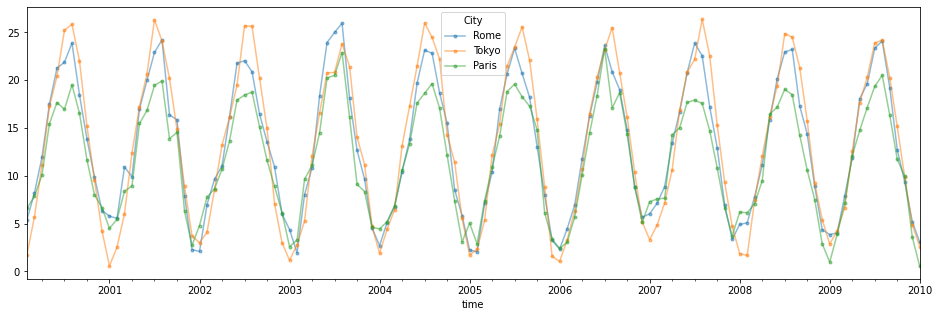

In [ ]:
df_cities_months[["Rome", "Tokyo", "Paris"]].plot(marker='.', alpha=0.5, figsize=(16, 5));

You can also plot the average temperature for each month during the period.

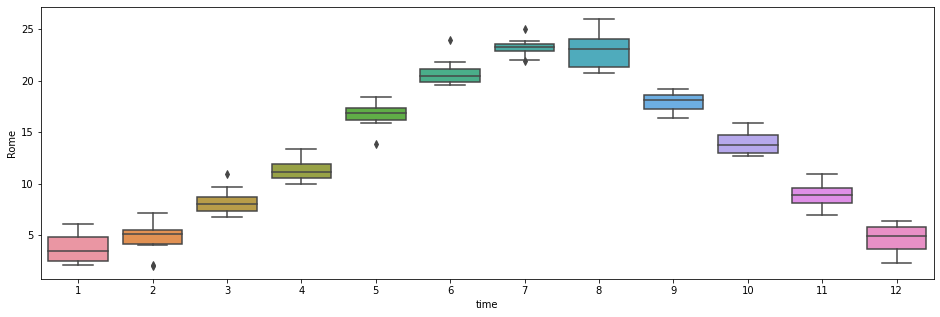

In [6]:
plt.figure(figsize=(16, 5))
sn.boxplot(data=df_cities_months, x=df_cities_months.index.month, y="Rome");

## **Clustering**

Use some different clustering techniques and show their results.

Import the libraries needed for the clustering techniques.

In [7]:
!pip install tslearn

     |████████████████████████████████| 793 kB 4.2 MB/s 


In [8]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tslearn.metrics.dtw_variants import pairwise_distances

Method for the k-means analysis to find the best k value.

In [9]:
def k_means(x_cluster, i_cluster, max_k):
    sse_list = list()
    sil_list = list()
    davies_list = list()
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Dataframe {0}, iterating over {1} possible K values".format(i_cluster, max_k)):
        kmeans_iter = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=max_k, random_state=0)
        kmeans_iter.fit(x_cluster)
        
        davies_list.append(davies_bouldin_score(x_cluster, kmeans_iter.labels_))
        sil_list.append(silhouette_score(x_cluster, kmeans_iter.labels_))
        sse = kmeans_iter.inertia_
        sse_list.append(sse)

    return sse_list, sil_list, davies_list

Method to plot the SSE, Silhouette and Davies-Bouldin scores.

In [10]:
def plot_indicators(i_cluster, max_k, sse_list, sil_list, davies_list):

    # plot indicators
    fig, axs = plt.subplots(3, 1, figsize=(10, 14));
    label_s = 10

    # SSE
    axs[0].plot(range(2, len(sse_list) + 2), sse_list)
    axs[0].set_ylabel('SSE', fontsize=16)
    axs[0].set_xlabel('K', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0].set_xticks(range(2, max_k+1));

    # Silhouette
    axs[1].plot(range(2, len(sil_list) + 2), sil_list)
    axs[1].set_ylabel('Silhouette Score', fontsize=16)
    axs[1].set_xlabel('K', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1].set_xticks(range(2,max_k+1));

    # Davies-Bouldin Score
    axs[2].plot(range(2, len(davies_list) + 2), davies_list)
    axs[2].set_ylabel('Davies-Bouldin Score', fontsize=16)
    axs[2].set_xlabel('K', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=label_s)
    axs[2].set_xticks(range(2,max_k+1));

    axs[0].set_title("Dataframe {0}, indicators".format(i_cluster), fontsize=22)

### **Shape-based clustering**

Perform clustering based on the shape of the timeseries.

In [11]:
sse, sil, davies_bouldin = k_means(df_cities, "Cities", 20)

Dataframe Cities, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Plot the results of the analysis (SSE, Silhouette and Davies-Bouldin scores) for each value of k.

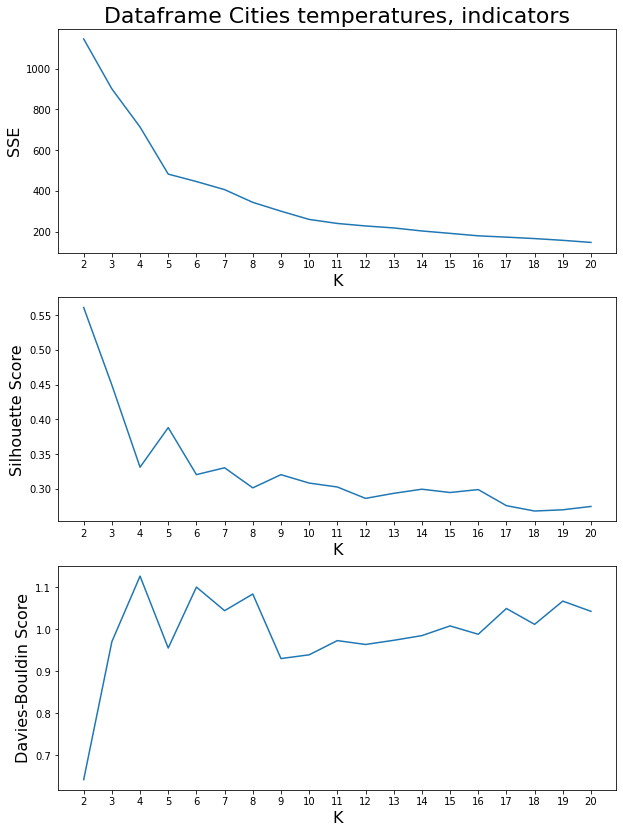

In [12]:
plot_indicators("Cities temperatures", 20, sse, sil, davies_bouldin)

By using the elbow rule for the SSE graph and looking at the other two, we saw that the best value for k is 5, we proceed with our analysis.

In [13]:
k = 5  # best k value
kmeans = TimeSeriesKMeans(n_clusters=k, n_init=100)
kmeans.fit(df_cities)
print("SSE:", sse[k-2], " - SILHOUETTE:", sil[k-2])

SSE: 483.00006696354694  - SILHOUETTE: 0.3882569665611318


Let's see how many cities are in each cluster.

In [14]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

{0: 29, 1: 34, 2: 9, 3: 15, 4: 13}


Plot the clusters.

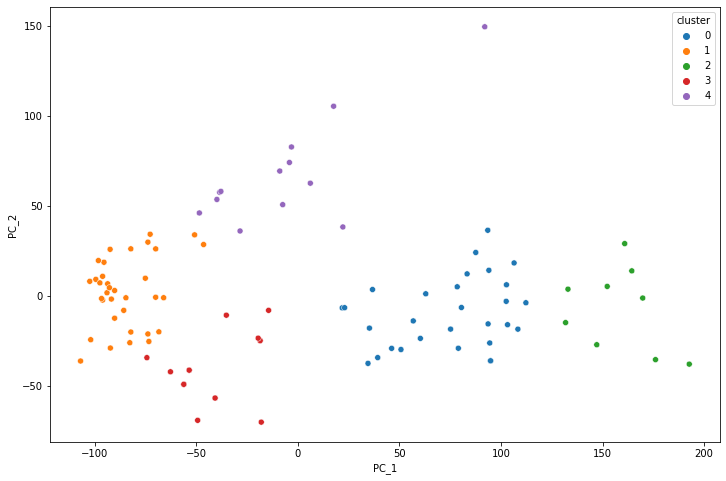

In [15]:
pca = PCA(n_components=2)
df_pca = df_cities.copy()
df_pca.columns = df_pca.columns.astype(str)
data_to_visualize = pd.DataFrame(pca.fit_transform(df_pca), columns=['PC_1','PC_2'], index=df_cities.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

In [16]:
def plot_basic_statistics(df, labels, columns):
    df_plot = pd.DataFrame(df, columns=columns, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]     
    means = []
    std = []
    label_s = 12
    fig = plt.figure(figsize=(19, 8))
    for i in np.unique(df_plot['cluster'].array):
        clust = df.loc[df_plot['cluster'] == i, df.columns.month==columns]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)  
    legend = []
    for i in np.unique(df_plot['cluster'].array):
        plt.plot(range(0, columns.shape[0]), means[i], marker='o')
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns, fontsize=label_s, rotation=89)
    plt.tight_layout()

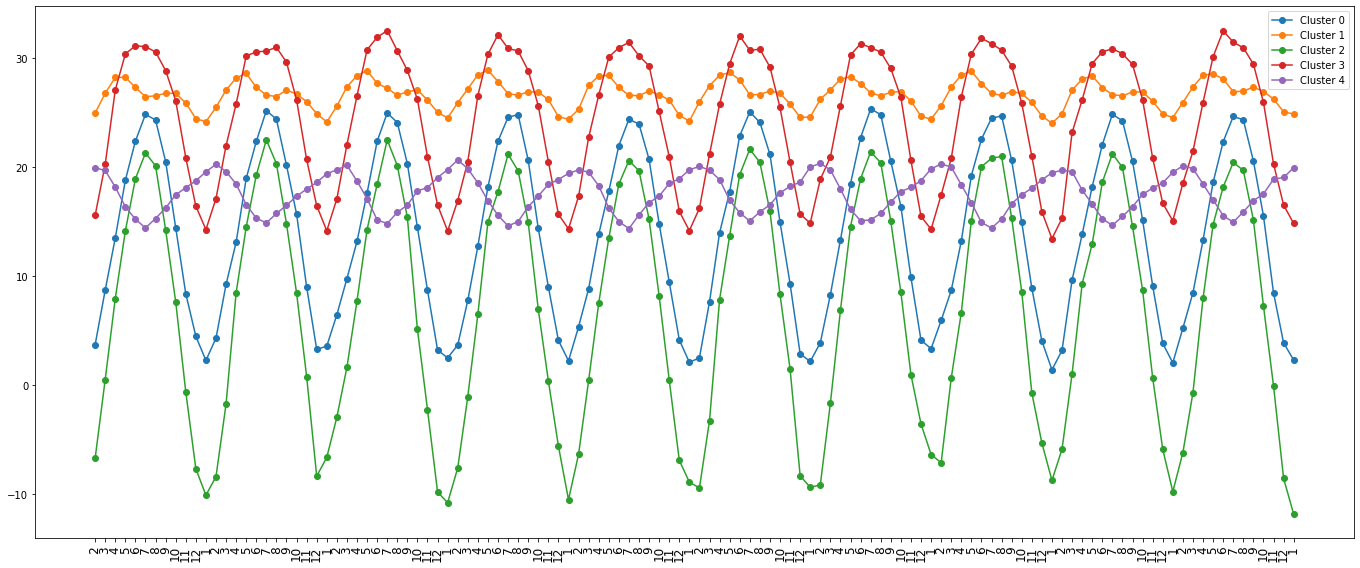

In [17]:
clusters_cities = kmeans.labels_
plot_basic_statistics(df_cities, clusters_cities, df_cities.columns.month)

In [18]:
df_cities_plot = df_cities.copy()
df_cities_plot["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cities_plot.groupby("cluster").mean()

time,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,2001-06-01,2001-07-01,2001-08-01,2001-09-01,2001-10-01,2001-11-01,2001-12-01,2002-01-01,2002-02-01,2002-03-01,2002-04-01,2002-05-01,2002-06-01,2002-07-01,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,2003-04-01,2003-05-01,...,2006-10-01,2006-11-01,2006-12-01,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,2007-10-01,2007-11-01,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.716379,8.729517,13.517517,18.818310,22.411690,24.865724,24.354103,20.538966,14.466448,8.410345,4.490138,2.283414,4.325448,9.253724,13.130069,18.984517,22.376862,25.215034,24.423793,20.193621,15.725103,9.038172,3.292414,3.590966,6.477586,9.791034,13.200931,17.628034,22.389966,25.000517,24.116448,20.348724,14.490276,8.718586,3.236000,2.513138,3.687724,7.789103,12.768069,18.207517,...,16.405793,9.898552,4.132828,3.362690,5.948621,8.707414,13.239759,19.242000,22.588448,24.514448,24.729483,20.637069,14.975310,8.925724,4.063310,1.422034,3.200000,9.656483,13.858724,18.244621,22.083690,24.874897,24.276862,20.558207,15.167448,9.118724,3.841345,2.060103,5.242655,8.492759,13.320724,18.622207,22.357448,24.671586,24.373276,20.586862,15.553655,8.483862,3.888138,2.319724
1,24.983088,26.807147,28.255941,28.275647,27.335500,26.489235,26.571500,26.807324,26.792853,25.922912,24.469147,24.189559,25.511794,27.094794,28.212265,28.628529,27.353824,26.636324,26.501824,27.107882,26.725794,26.042618,24.925794,24.170882,25.624412,27.401588,28.413765,28.887147,27.719794,27.257206,26.625147,26.942382,27.116235,26.167559,25.057824,24.535647,25.936735,27.201176,28.501529,28.918941,...,26.960618,26.101912,24.684794,24.425029,25.669176,27.369412,28.476088,28.838853,27.697235,26.796294,26.600147,26.963353,26.784059,25.970029,24.711353,24.057971,24.915059,27.095559,28.091235,28.409618,27.322971,26.681765,26.566559,26.925471,26.916588,26.081000,24.905912,24.576471,25.955882,27.380794,28.463971,28.583912,28.119735,26.941294,26.997500,27.367353,26.964471,26.278147,25.104382,24.895059
2,-6.714556,0.525000,7.959111,14.157556,18.959556,21.320000,20.145556,14.267889,7.661444,-0.611444,-7.668000,-10.090444,-8.394111,-1.726111,8.488000,14.528000,19.286889,22.524333,20.343000,14.816111,8.467667,0.802889,-8.343889,-6.621333,-2.929778,1.646111,7.747444,14.284000,18.437889,22.527444,20.167111,15.410667,5.135333,-2.239778,-9.802333,-10.777111,-7.599889,-1.044111,6.506111,14.988333,...,8.516222,0.969222,-3.554444,-6.360889,-7.113444,0.650889,6.672556,15.123000,20.049778,20.842667,21.000333,15.348667,8.576778,-0.688222,-5.306000,-8.725889,-5.874111,1.031667,9.312111,12.993222,18.636222,21.240333,20.003000,14.579778,8.727556,0.700111,-5.880889,-9.763111,-6.178444,-0.679778,7.965556,14.747444,18.199889,20.449667,19.732667,15.176889,7.278667,-0.055222,-8.552222,-11.831222
3,15.590000,20.276133,27.104267,30.407467,31.169133,31.084000,30.596400,28.890867,26.125200,20.895067,16.446067,14.289733,17.135733,21.991800,25.819933,30.231200,30.597933,30.677267,31.025200,29.648600,26.209200,20.724000,16.483467,14.184867,17.109000,22.085000,26.569133,30.797267,31.936267,32.558267,30.708867,28.909067,26.242667,20.980000,16.548800,14.160400,16.947200,20.529333,26.589200,30.377867,...,26.428533,20.634333,15.503000,14.318000,17.462933,20.825933,26.463600,30.416867,31.845067,31.367933,30.756867,29.299867,25.890333,21.039000,15.927267,13.454933,15.321267,23.206000,26.195667,29.535533,30.606600,30.890333,30.440333,29.446000,26.212867,2

In [95]:
import plotly.graph_objs as plt_go

df_cities_locations = df_cities_temperatures[["City", "Country", "Latitude", "Longitude"]].drop_duplicates()
for i, city in df_cities_locations.iterrows():
    if "S" in city["Latitude"]:
        df_cities_locations.loc[i]["Latitude"] = "-" + df_cities_locations.loc[i]["Latitude"]
    
    df_cities_locations.loc[i]["Latitude"] = df_cities_locations.loc[i]["Latitude"][:-1]
    if "W" in city["Longitude"]:
        df_cities_locations.loc[i]["Longitude"] = "-" + df_cities_locations.loc[i]["Longitude"]
    
    df_cities_locations.loc[i]["Longitude"] = df_cities_locations.loc[i]["Longitude"][:-1]

df_cities_locations[["Longitude", "Latitude"]] = df_cities_locations[["Longitude", "Latitude"]].astype("Float32")
df_cities_locations["cluster"] = kmeans.labels_  # insert the column "cluster"

fig = plt_go.Figure()
for cluster in range(k):
    fig.add_trace(plt_go.Scattergeo(
        mode = "markers",
        lon = df_cities_locations[df_cities_locations["cluster"]==cluster]["Longitude"],
        lat = df_cities_locations[df_cities_locations["cluster"]==cluster]["Latitude"],
        text = df_cities_locations[df_cities_locations["cluster"]==cluster]['City'] + ", " + df_cities_locations[df_cities_locations["cluster"]==cluster]["Country"],
        legendgroup = "Cluster " + str(cluster),
        name = "Cluster " + str(cluster),
    ))
'''    
fig = plt_go.Figure(
    data=plt_go.Scattergeo(
        mode = "markers",
        lon = df_cities_locations["Longitude"],
        lat = df_cities_locations["Latitude"],
        text = df_cities_locations['City'] + ", " + df_cities_locations["Country"],
        marker_color = df_cities_locations['cluster'],
        legendgroup = df_cities_locations["cluster"],
    ))'''
fig.update_layout(title_text='Cities clusters')

fig.show()

In [ ]:
def plot_similarity_heatmap(df, labels):
    df_plot = pd.DataFrame(df, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]
    df_plot.sort_values(by='cluster', ascending=True, inplace=True)
    dist = pairwise_distances(df_plot.loc[:, columns], df_plot.loc[:, columns],  metric="correlation")
    similarity = np.exp(-dist)
    fig, ax = plt.subplots(figsize=(12,8))
    sn.heatmap(similarity, ax=ax, cmap='coolwarm')

In [ ]:
clusters_cities = kmeans.labels_
plot_similarity_heatmap(df_cities, clusters_cities)

In [ ]:
# plt.plot(kmeans.cluster_centers_.reshape(df_cities.shape[1], 5))
plt.plot(kmeans.cluster_centers_.reshape(5, df_cities.shape[1]))
plt.show()